__Problem: Given the data set your task is to predict the tags associated with a recipe.__

### Approach and Steps to solve the problem

* The required dataset that is provided is highly uncleaned and unbalanced.
* So the first step is to clean and preprocess the data. As in the dataset some columns have missing values so I drop them as they are few in number but some have lot of missing values or list like prep_time,cuisine and cooking time so for them I introduce new value and fill all those null values with the introduced value.
* After getting the cleaned text I perfrom some data analysis on the tags try to identify which are the most favored tags, how many tags are there, build a wordcloud etc.
* As there are total 776 tags and predicting all of them is a computation heavy task because it is a multi label classification problem so to deal with these problem I have taken the top 200 tags which covers about 99.4% of the recipes that we have.
* In this problem I have used Average W2V technique for text(recipe) vectorization. We can also used tf-idf W2V, tf-idf and many other but for simplicity I have used only one.
* After getting all the data in required format I perform 80:20 train test split and perform modelling with OneVsRest classifier with Logistic Regression and SVM as it is a multi label classification problem.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import gensim
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from bs4 import BeautifulSoup
import seaborn as sns

In [2]:
# Reading data
data=pd.read_csv('recipes_82k.csv')
data.head(3)

,category,cooking_method,cuisine,image,ingredients,prep_time,recipe_name,serves,tags
0,NaN,['Set the racks in the middle and upper thirds...,['American'],https://www.skinnytaste.com/wp-content/uploads...,"['1 tablespoons extra virgin olive oil', '1 cu...",20 minutes,Mediterranean Sea Bass,4 servings,"Dairy Free, Gluten Free, Keto Recipes, Kid Fri..."
1,NaN,['Place the eggs in the air fryer basket and c...,['American'],https://www.skinnytaste.com/wp-content/uploads...,"['4 large eggs', 'Salt (black pepper, everythi...",15 minutes,Air Fryer Hard Boiled Eggs,4 eggs,"Air Fryer Recipes, Dairy Free, Gluten Free, Ke..."
2,NaN,"['Air Fryer directions:', 'Preheat air fryer t...",['American'],https://www.skinnytaste.com/wp-content/uploads...,"['olive oil spray', '4 about 5 ounce each salm...",5 minutes,Air Fryer Basil-Parmesan Salmon,4 servings,"Air Fryer Recipes, Gluten Free, Keto Recipes, ..."


In [3]:
# no of rows and columns
data.shape

(82245, 9)

In [4]:
#Taking only the required fields
data=data[['cooking_method','cuisine','ingredients','prep_time','recipe_name','serves','tags']]
data.tail(2)

,cooking_method,cuisine,ingredients,prep_time,recipe_name,serves,tags
82243,"[""In a medium soup pot, heat the olive oil, th...",[],"['1/4 cup olive oil, plus more to drizzle', '1...",NaN,"Zucchini, Potato and Fennel Stew",4 servings,"Make Ahead,Stew Recipes,Potato,Vegetable,Zucch..."
82244,"['Directions', 'With a hand grater, grate the ...",[],"['1 large zucchini', '2 large russet potatoes,...",32.0 minutes,"Zucchini, Carrot and Potato Pancakes Recipe",0,"Potato Pancake,Pancake,Potato,Vegetable,Vegeta..."


### Data Cleaning and Preprocessing

In [5]:
#checking null values in each and every column
for i in list(data.columns):
    print(i,"has",data[i].isnull().sum(axis = 0),"null values")

cooking_method has 0 null values
cuisine has 15 null values
ingredients has 0 null values
prep_time has 23615 null values
recipe_name has 0 null values
serves has 1 null values
tags has 234 null values


In [6]:
#dropping null values from cuisine, serves and tags column
data = data[pd.notnull(data['cuisine'])]
data = data[pd.notnull(data['serves'])]
data = data[pd.notnull(data['tags'])]
data.shape

(81995, 7)

In [7]:
data=data.reset_index()

In [8]:
data['prep_time'].value_counts()

P0Y0M0DT0H10M0.000S            11043
P0Y0M0DT0H15M0.000S             9713
P0Y0M0DT0H20M0.000S             8045
P0Y0M0DT0H5M0.000S              6516
P0Y0M0DT0H30M0.000S             4651
P0Y0M0DT0H25M0.000S             2918
0 minutes                       1977
P0Y0M0DT0H45M0.000S             1300
P0Y0M0DT0H40M0.000S             1089
P0Y0M0DT1H0M0.000S              1008
P0Y0M0DT0H35M0.000S              954
10.0 minutes                     505
61.0 minutes                     435
P0Y0M0DT0H2M0.000S               367
10 minutes                       319
P0Y0M0DT0H50M0.000S              308
P0Y0M0DT0H12M0.000S              298
P0Y0M0DT0H8M0.000S               284
5.0 minutes                      266
P0Y0M0DT1H30M0.000S              266
15.0 minutes                     260
20.0 minutes                     250
P0Y0M0DT0H3M0.000S               215
15 minutes                       209
5 minutes                        201
P0Y0M0DT2H0M0.000S               187
P0Y0M0DT1H15M0.000S              168
3

In [9]:
# As preparation time has lot of null values about 23615 so we will try to replace the null values by adding a new value i.e 10 minutes
data['prep_time'].fillna('10 minutes', axis=0, inplace=True)

In [10]:
#checking duplicates rows
df_no_dup=data.groupby(['cooking_method','cuisine','ingredients','prep_time','recipe_name','serves','tags']).size().reset_index(name='counts')

In [11]:
print("No of duplicate rows",data.shape[0]-df_no_dup.shape[0],"(",(1-((df_no_dup.shape[0])/(data.shape[0])))*100,"% )")

No of duplicate rows 18505 ( 22.568449295688765 % )


In [12]:
# number of times each recipe appeared in our database
df_no_dup.counts.value_counts()

1    45350
2    17888
3      146
4      102
6        3
5        1
Name: counts, dtype: int64

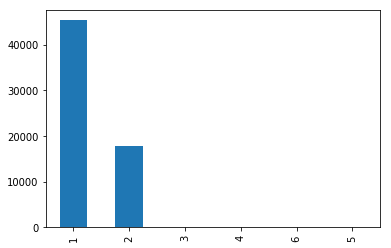

In [85]:
df_no_dup.counts.value_counts().plot.bar()
plt.show()

* From the above plot we can find that majority of the rows are unique. Only few of them are duplicates.

In [15]:
df_no_dup["tags_count"] = df_no_dup["tags"].apply(lambda a: len(a.split(',')))

In [16]:
df_no_dup['cuisine'].value_counts()

[]                                    62107
['American']                           1018
['Italian']                             145
['Mexican']                              93
['Chinese', 'Japanese']                  67
['Mediterranean']                        18
['Indian']                                9
['American', 'Italian']                   7
['American', 'Mexican']                   5
['Asian']                                 4
['Latin']                                 3
['Latin', 'Mexican']                      2
['American', 'Latin']                     2
['American', 'Tex Mex']                   1
['Asian', 'Chinese']                      1
['American', 'Cuban', 'Latin']            1
['Cuban', 'Latin']                        1
['Brazilian']                             1
['American', 'Czech', 'Hungarian']        1
['Asian', 'Hawaiian']                     1
['American', 'Greek']                     1
['Tex Mex']                               1
['American', 'Argentinian']     

### Note: As there are about 62107 empty list present in cuisine field so I have to fill these values by introducing some other cuisine value as 'unknown'

In [17]:
df_no_dup['ingredients'].value_counts()

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### Note: Similarly there are about 947 empty list present in ingredients field so I have to fill these values by introducing some other ingredients value as 'unknown'

In [18]:
df_no_dup['cooking_method'].value_counts()

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### Note: Similarly there are about 32 empty list present in cooking_method field so I have to fill these values by introducing some other cooking_method value as 'unknown'

In [19]:
# filling the empty list values by 'unknown' value
df_no_dup['cuisine']=df_no_dup['cuisine'].apply(lambda x: '[unknown]' if x=='[]' else x)
df_no_dup['ingredients']=df_no_dup['ingredients'].apply(lambda x: '[unknown]' if x=='[]' else x)
df_no_dup['cooking_method']=df_no_dup['cooking_method'].apply(lambda x: '[unknown]' if x=='[]' else x)

<h2> Performing Exploratory Data Analysis  </h2>

<h3> Total number of unique tags </h3>

In [20]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(df_no_dup['tags'])

In [21]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 63490
Number of unique tags : 776


In [22]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : [' dairy free', ' freezer meals', ' gluten free', ' keto recipes', ' kid friendly', ' low carb', ' meal prep recipes', ' paleo', ' pressure cooker recipes', ' slow cooker recipes']


<h3> Number of times a tag appeared </h3>

In [23]:
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [24]:
tag_df=pd.DataFrame(list(result.items()), columns=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,dairy free,13
1,freezer meals,67
2,gluten free,523
3,keto recipes,247
4,kid friendly,444


In [25]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

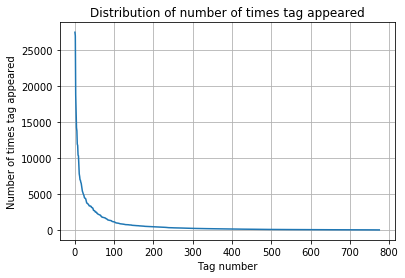

In [26]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

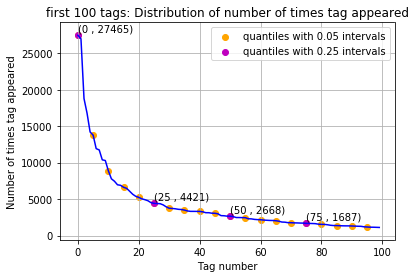

In [27]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate("(%s , %s)"%(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [28]:
# Store tags greater than 2K in one list
lst_tags_gt_2k = tag_df[tag_df.Counts>2000].Tags
#Print the length of the list
print ('{} Tags are used more than 2000 times'.format(len(lst_tags_gt_2k)))

66 Tags are used more than 2000 times


<h3> Tags Per Recipe </h3>

In [29]:
#Storing the count of tag 
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))

Maximum number of tags per question: 36
Minimum number of tags per question: 1


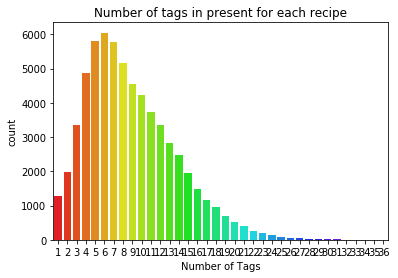

In [30]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags present for each recipe")
plt.xlabel("Number of Tags")
plt.show()

<h3> Most Frequent Tags </h3>

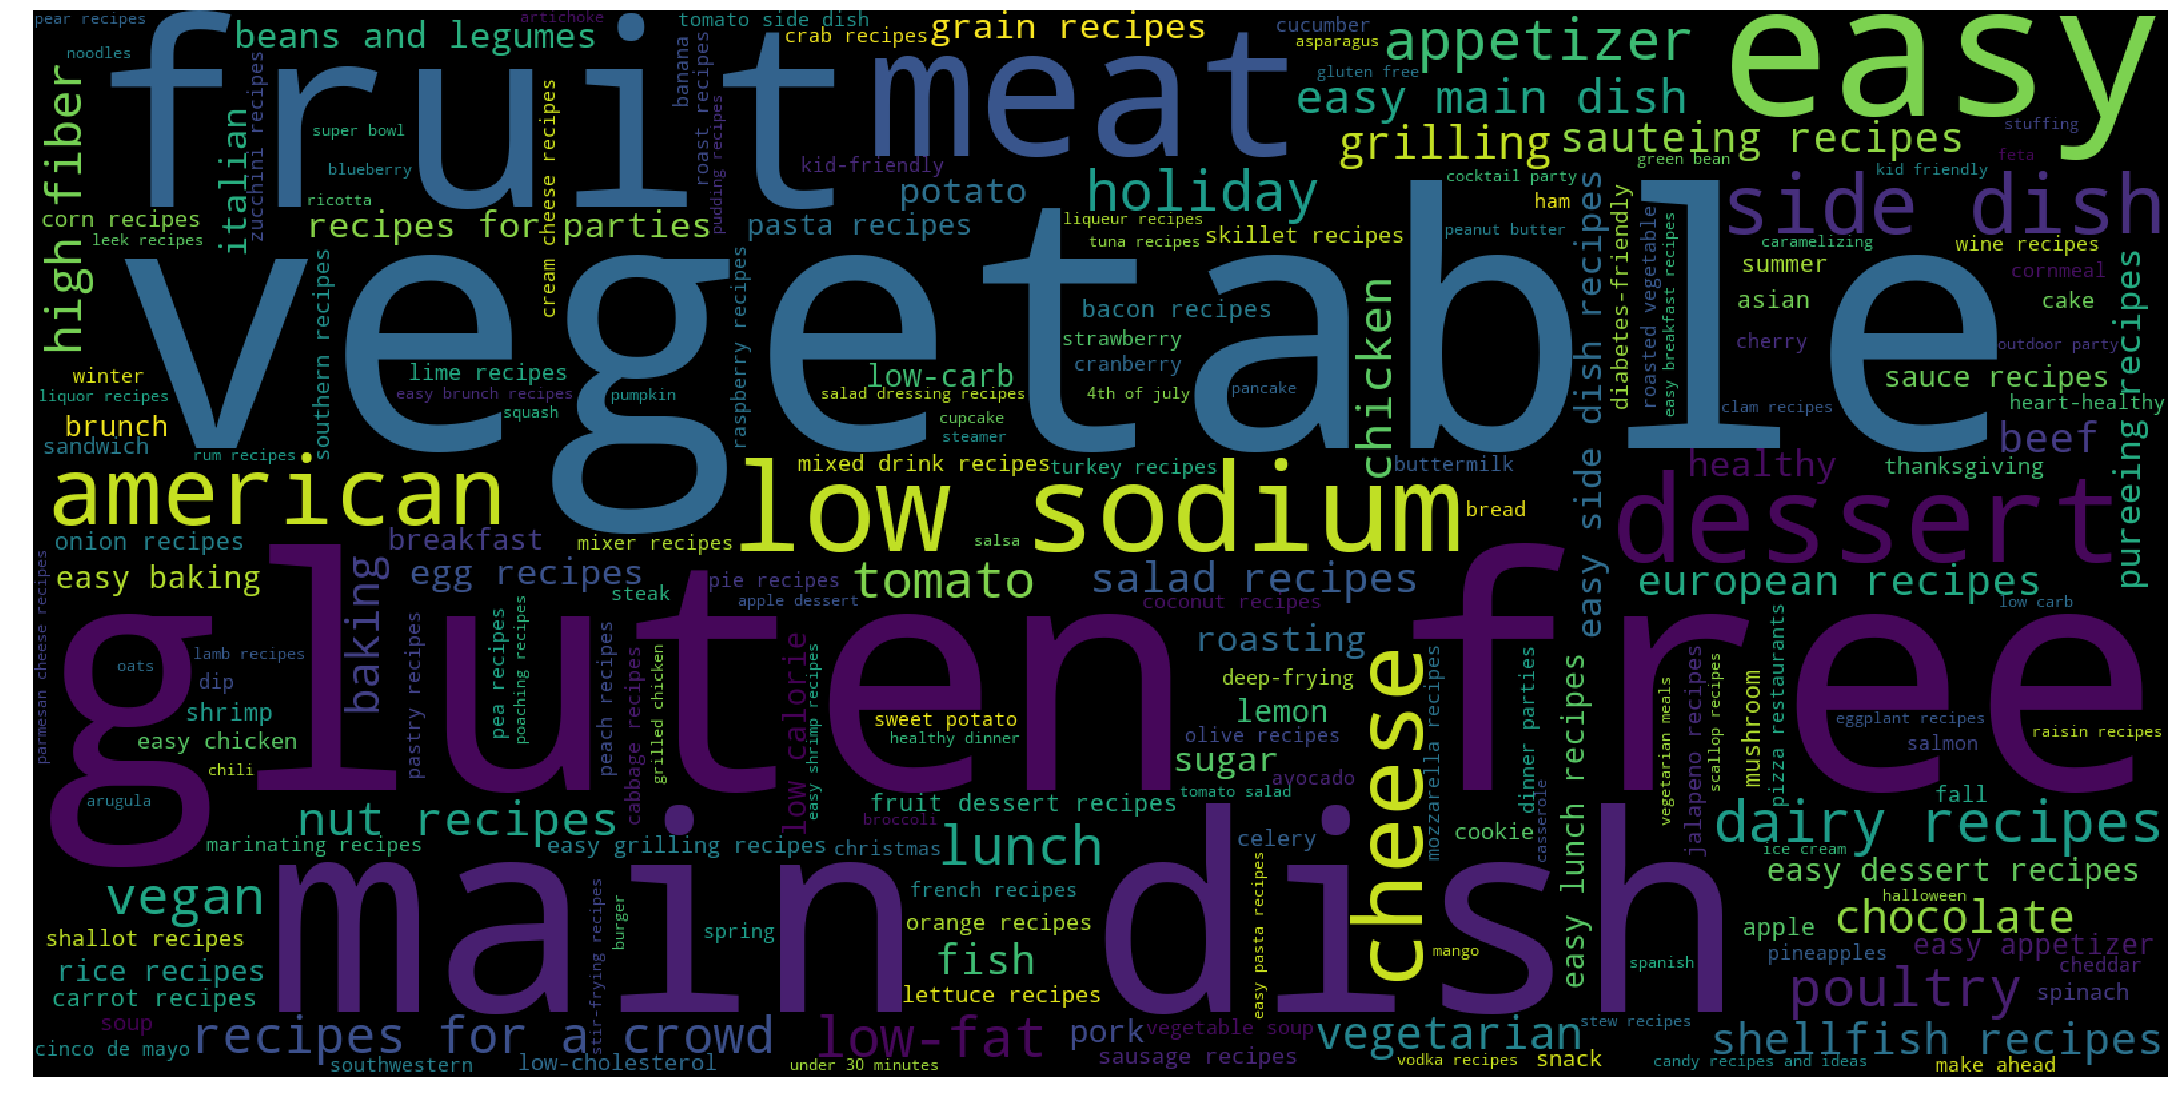

In [31]:

tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<h3> The top 30 tags </h3>

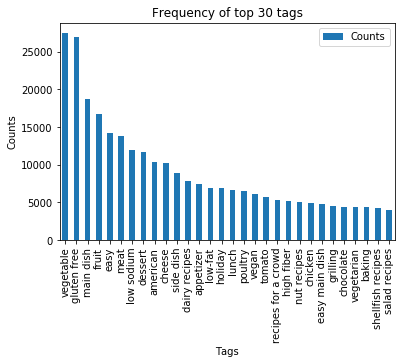

In [32]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 30 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

__Merging all the field into one field to get the complete information about the recipe so from that related tags can be found out__ 

In [33]:
df_no_dup['info'] = df_no_dup['cooking_method'] + " " + df_no_dup['cuisine']+" "+df_no_dup['ingredients']+" "+df_no_dup['prep_time']+" "+df_no_dup['recipe_name']+" "+df_no_dup['serves']

In [34]:
df_no_dup['info'].iloc[0]

'["*Cook\'s Note: Depending on your heat preference, you may remove the seeds from the jalapenos or leave them intact.", \'Set 1 of the oven racks on the lowest shelf and preheat oven to 350 degrees F.\', \'Line a baking pan with parchment paper. Make 8 (2-inch) balls out of aluminum foil. Spray 3 wire cooling racks with non-stick cooking spray and place 1 of the aluminum balls in each of the corners of 2 of the racks.\', \'Lay 1/3 of the chips on one of the racks. Top each chip with a jalapeno slice and sprinkle the chips with 1/3 of the red onions, and 1/3 of both the Cheddar and Oaxaca cheeses. Repeat with the remaining chips and the other 2 racks. Stack the racks on top of one another and set into the parchment lined baking pan. Bake in the oven on the bottom rack for 7 minutes or until the cheese begins to bubble. Sprinkle with fresh oregano. Serve immediately with the salsa, sour cream, and guacamole.\'] [unknown] [\'80 corn tortilla chips, approximately 8 ounces\', \'3 to 4 jala

### Text preprocessing

In [35]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [36]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [37]:
preprocessed_text = []
# tqdm is for printing the status bar
for sentance in tqdm(df_no_dup['info'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_text.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 63490/63490 [01:01<00:00, 1027.89it/s]


In [38]:
# Cleaned information about the recipe
df_no_dup['CleanedInfo']=preprocessed_text

In [39]:
df_no_dup['CleanedInfo'].iloc[0]

'cook note depending heat preference may remove seeds jalapenos leave intact set 1 oven racks lowest shelf preheat oven 350 degrees f line baking pan parchment paper make 8 2 inch balls aluminum foil spray 3 wire cooling racks non stick cooking spray place 1 aluminum balls corners 2 racks lay 1 3 chips one racks top chip jalapeno slice sprinkle chips 1 3 red onions 1 3 cheddar oaxaca cheeses repeat remaining chips 2 racks stack racks top one another set parchment lined baking pan bake oven bottom rack 7 minutes cheese begins bubble sprinkle fresh oregano serve immediately salsa sour cream guacamole unknown 80 corn tortilla chips approximately 8 ounces 3 4 jalapenos thinly sliced 4 1 2 ounces diced red onion approximately 1 cup 6 ounces finely grated cheddar approximately 2 1 4 cups 6 ounces finely grated oaxaca cheese approximately 2 1 4 cups 2 tablespoons finely chopped fresh oregano leaves 2 cups fresh salsa 2 cups sour cream 2 cups guacamole p0y0m0dt0h20m0 000s ultimate nachos 80 na

In [40]:
# new dataframe with only information and the related tags
new_data=df_no_dup[['CleanedInfo','tags']]
new_data.head(2)

,CleanedInfo,tags
0,cook note depending heat preference may remove...,"Easy Chicken,Chicken,Easy,Poultry,American,Sou..."
1,cook note dulce de leche sold hispanic aisle s...,"Coffee Drinks,Chocolate,Gluten Free,Low Sodium"


In [41]:
print("number of data points in sample :", new_data.shape[0])
print("number of dimensions :", new_data.shape[1])

number of data points in sample : 63490
number of dimensions : 2


<h2> Converting tags for multilabel problems </h2>

In [42]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','), binary='true')
multilabel_y = vectorizer.fit_transform(new_data['tags'])

__Handling Conflicting tags problem__

In [43]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def recipes_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

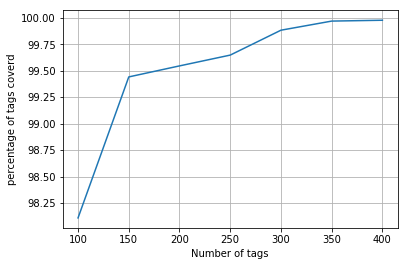

with  200 tags we are covering  99.441 % of recipes
with  500 tags we are covering  99.976 % of recipes


In [46]:
fig, ax = plt.subplots()
ax.plot(recipes_explained)
xlabel = list(np.array(range(50,700,50)))
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("percentage of tags coverd")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power
print("with ",200,"tags we are covering ",recipes_explained[1],"% of recipes")
print("with ",500,"tags we are covering ",recipes_explained[6],"% of recipes")

In [47]:
multilabel_yx = tags_to_choose(200)
print("number of recipes that are not covered :", recipes_explained_fn(200),"out of", total_recipe)

number of recipes that are not covered : 355 out of 63490


__Note: Instead of taking all the tags we are taking only the top 200 tags due to computation issue__

__Note: By taking 200 tags only 355 out of 63490 recipes are not covered__

<h2>Split the data into test and train (80:20) </h2>

In [48]:
total_size=new_data.shape[0]
train_size=int(0.80*total_size)

x_train=new_data.head(train_size)
x_test=new_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [49]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (50792, 200)
Number of data points in test data : (12698, 200)


In [50]:
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
#stop = set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub('[^A-Za-z0-9]+',' ',sentence)
    return  cleaned

In [58]:
list_of_sent=[]
    
for sent in x_train['CleanedInfo'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

### Applying Average W2V technique for vectorization

In [60]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [61]:
w2v_words = list(w2v_model.wv.vocab)

In [62]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(x_train['CleanedInfo'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 50792/50792 [18:49<00:00, 39.62it/s]


50792
50


In [63]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(x_test['CleanedInfo'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|████████████████████████████████████████████████████████████████████████████| 12698/12698 [05:09<00:00, 41.00it/s]


12698
50


In [64]:
x_train_multilabel=sent_vectors
x_test_multilabel =sent_vectors_test

### Data Modelling

In [67]:
classifier1 = OneVsRestClassifier(LogisticRegression())


classifier1.fit(x_train_multilabel, y_train)

predictions = classifier1.predict(x_test_multilabel)

C:\Users\abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

In [90]:
print("Root-Mean-Squared-Logarithmic-Error with Logistic Regression :",np.sqrt(mean_squared_log_error(y_test.toarray(), predictions.toarray())))

Root-Mean-Squared-Logarithmic-Error with Logistic Regression : 0.12638373809103873


In [ ]:
classifier2 = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', alpha=1, penalty='l2',n_jobs=-1))
classifier2.fit(x_train_multilabel, y_train)
predictions2 = classifier2.predict (x_test_multilabel)


In [91]:
print("Root-Mean-Squared-Logarithmic-Error with SVM :",np.sqrt(mean_squared_log_error(y_test.toarray(), predictions2.toarray())))

Root-Mean-Squared-Logarithmic-Error with SVM : 0.1365663860692787


In [ ]:
classifier_3 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_3.fit(x_train_multilabel, y_train)

predictions_3 = classifier_3.predict(x_test_multilabel)

In [92]:
print("Root-Mean-Squared-Logarithmic-Error with L1 Logistic Regression :",np.sqrt(mean_squared_log_error(y_test.toarray(), predictions_3.toarray())))

Root-Mean-Squared-Logarithmic-Error with L1 Logistic Regression : 0.12638074424441945


### Pipeline for test data

In [ ]:
def pipeline(df_no_dup):
    df_no_dup['info'] = df_no_dup['cooking_method'] + " " + df_no_dup['cuisine']+" "+df_no_dup['ingredients']+" "+df_no_dup['prep_time']+" "+df_no_dup['recipe_name']+" "+df_no_dup['serves']
    vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','), binary='true')
    multilabel_y = vectorizer.fit_transform(df_no_dup['tags'])
    multilabel_yx = tags_to_choose(200)
    
    preprocessed_test = []

    for sentance in tqdm(df_no_dup['info'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_test.append(sentance.strip())
        
    df_no_dup['CleanedInfo']=preprocessed_text    
        
    sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(df_no_dup['CleanedInfo'].values): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors_test.append(sent_vec)
        
    test_multilabel =sent_vectors_test 
    predictions_4 = classifier_3.predict(test_multilabel)
    print("Root-Mean-Squared-Logarithmic-Error:",np.sqrt(mean_squared_log_error(multilabel_yx.toarray(), predictions_4.toarray())))